## Importación

In [1]:
# Importacion de librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import linregress
from scipy.optimize import curve_fit

In [2]:
#Importación de datos
df = pd.read_csv("/content/GdFe2Zn20.txt", sep=r"\s+", skiprows=2, names=["Temp_K", "Xmol_emu/mol"], engine='python')

FileNotFoundError: [Errno 2] No such file or directory: '/content/GdFe2Zn20.txt'

##Datos

In [ ]:
#Tamaño
df.shape

In [ ]:
#Información de los datos
df.info()

In [ ]:
#Vista Preliminar
df.head()

In [ ]:
#Resumen estadistico preliminar
df.describe()

##Información

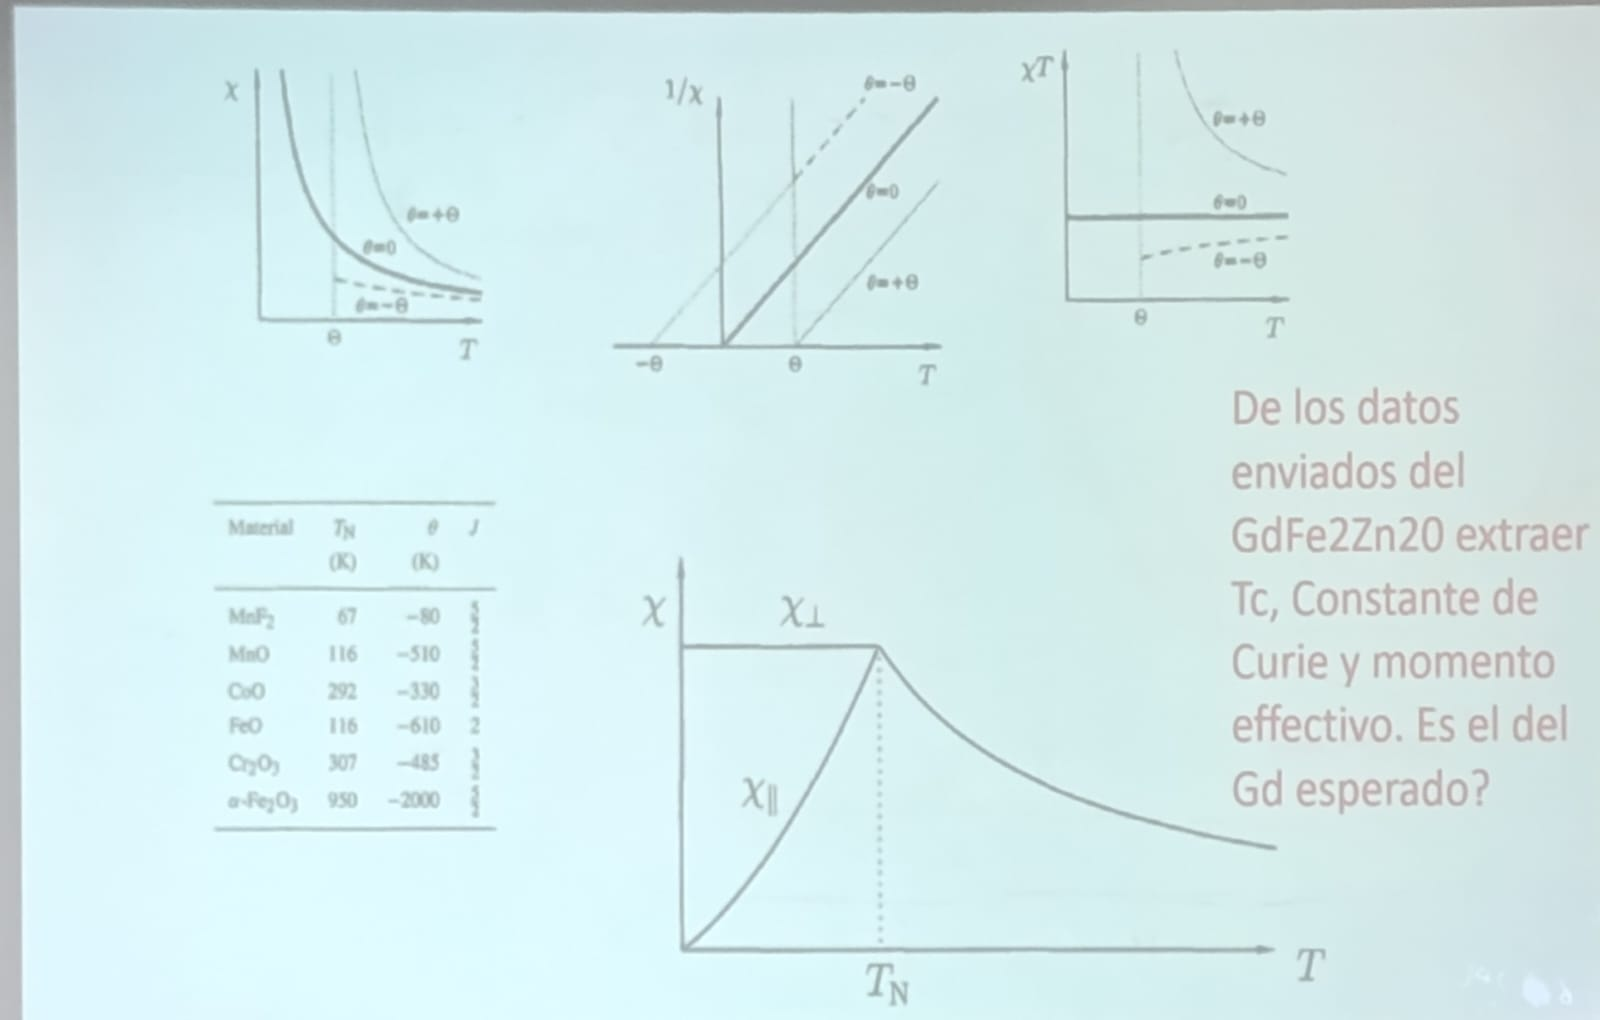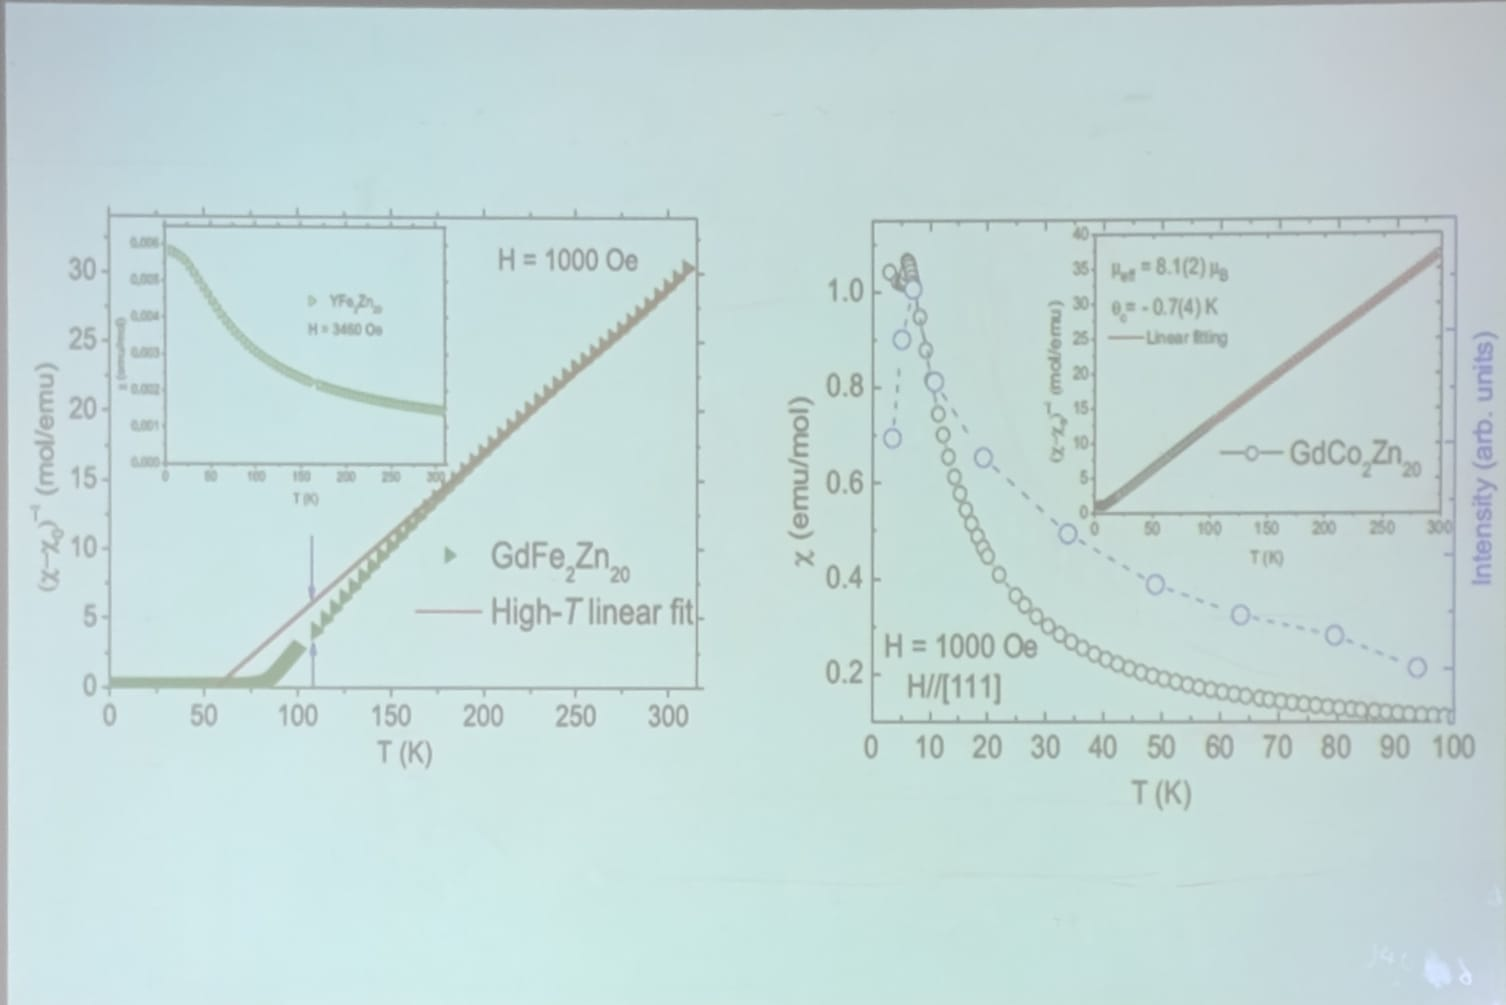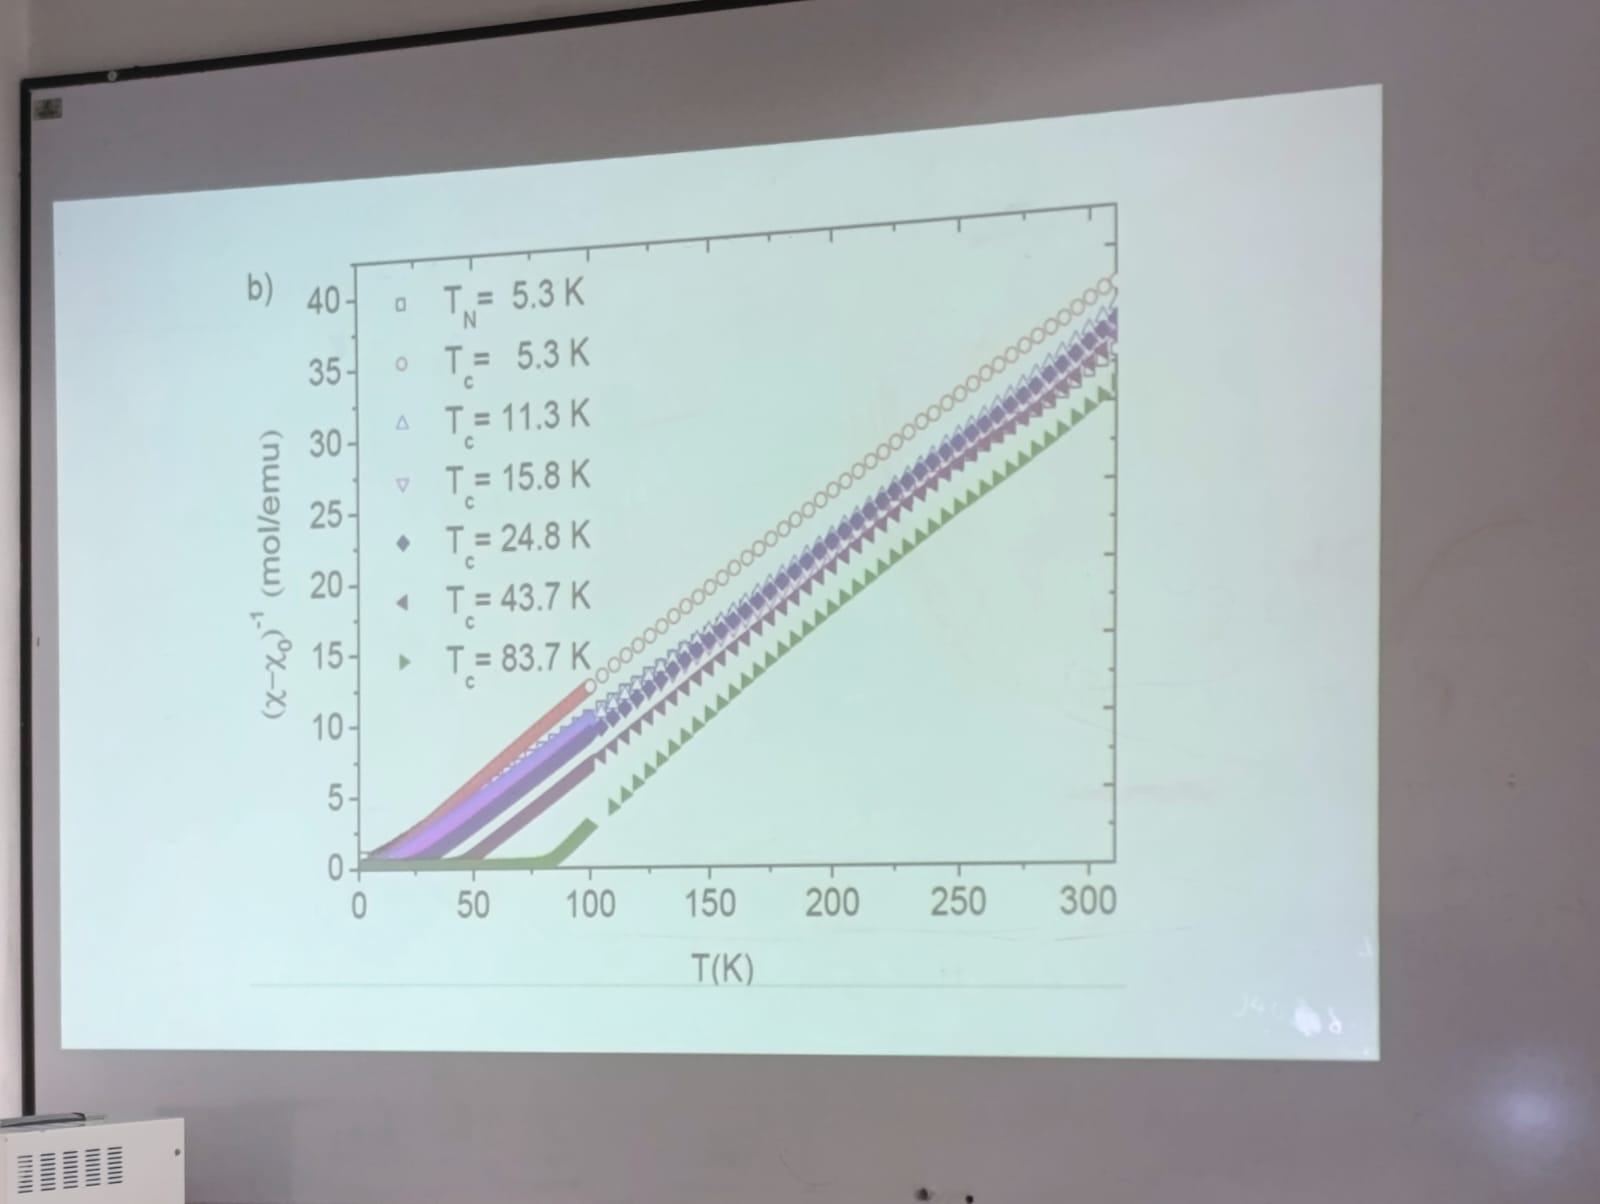

## Análisis

In [ ]:
df_filter = df[df["Temp_K"].between(100,310)]

window = 5 # tamaño de la ventana
threshold = 0.9995 # umbral mínimo de R²

rangos_lineales = []
for i in range(len(df_filter) - window + 1):
    subset = df_filter.iloc[i:i + window]
    x = subset["Temp_K"].values.reshape(-1, 1)
    y = subset["Xmol_emu/mol"].values
    model = LinearRegression().fit(x, y)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)

    if r2 >= threshold:
        chi_min = subset["Xmol_emu/mol"].min()
        chi_max = subset["Xmol_emu/mol"].max()
        rangos_lineales.append((chi_min, chi_max))

if rangos_lineales:
    chi_global_min = min(r[0] for r in rangos_lineales)
    chi_global_max = max(r[1] for r in rangos_lineales)
    print(f"La susceptibilidad se comporta linealmente (respecto a T) entre:\nχ mínima ≈ {chi_global_min:.4e} emu/mol y χ máxima ≈ {chi_global_max:.4e} emu/mol")

    # Visualización de datos para χ min y χ max
    temp_min = df.iloc[(df["Xmol_emu/mol"] - chi_global_max).abs().idxmin()]
    temp_max = df.iloc[(df["Xmol_emu/mol"] - chi_global_min).abs().idxmin()]

    print(f"Cuando χ ≈ {chi_global_max:.4e}, T ≈ {temp_min['Temp_K']} K")
    print(f"Cuando χ ≈ {chi_global_min:.4e}, T ≈ {temp_max['Temp_K']} K")
else:
    print("No se encontraron rangos donde la susceptibilidad sea lineal con la temperatura.")


In [3]:
# Obtener las temperaturas correspondientes a los valores de χ mínimos y máximos lineales
temp_min_val = df.iloc[(df["Xmol_emu/mol"] - chi_global_max).abs().idxmin()]["Temp_K"]
temp_max_val = df.iloc[(df["Xmol_emu/mol"] - chi_global_min).abs().idxmin()]["Temp_K"]

NameError: name 'df' is not defined

In [4]:
# Datos experimentales
rango_df = df[(df["Temp_K"] >=0 )]

# Crear figura
plt.figure(figsize=(8, 5))

# Graficar datos experimentales
plt.plot(rango_df["Temp_K"], 1/rango_df["Xmol_emu/mol"],
         color='black', linewidth=1, marker='o', markersize=3, label='Datos experimentales')

# Líneas verticales (si las tienes definidas)
plt.axvline(x=temp_min_val, color='red', linestyle='--', linewidth=1, label='Límite superior')
plt.axvline(x=temp_max_val, color='red', linestyle='--', linewidth=1, label='Límite superior')

# Etiquetas y formato
plt.xlabel("Temperatura (K)", fontsize=12)
plt.ylabel(r"Susceptibilidad (mol/emu)", fontsize=12)
plt.title(r"Curva de $1/\chi$ vs $T$", fontsize=13)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(direction='in', top=True, right=True)
plt.legend()
plt.tight_layout()

# Mostrar la figura
plt.show()

NameError: name 'df' is not defined

## Desarrollo

In [ ]:
# Extraer columnas como arrays
T = df["Temp_K"].values
chi = df["Xmol_emu/mol"].values

# Calcular la inversa de la susceptibilidad
chi_inv = chi

# Graficar
plt.figure(figsize=(7, 5))
plt.xlabel("T (K)")
plt.ylabel(r"$\chi$ (emu/mol)")
plt.title("Susceptibilidad vs Temperatura")

plt.plot(T, chi_inv, 'k^', label=fr'$GdFe_{2}Zn_{20}$', markersize=4)
# plt.axvline(x=T_c, color='gray', linestyle='--', linewidth=1, label=fr'$T_c$ ≈ {T_c:.2f} K ($T_c$ experimental)')
plt.axvline(x=83.7, color='blue', linestyle='--', linewidth=1, label=fr'$T_c$')

plt.legend(frameon=False, loc="best")
plt.grid(False)
plt.tight_layout()

# Etiquetas de fases
plt.text(20, 15, "Fase ferromagnética", fontsize=11, rotation=90, va='center')
plt.text(150, 5, "Fase paramagnética", fontsize=11, rotation=0)

# Ejes
ax = plt.gca()
for side in ["top", "bottom", "left", "right"]:
    ax.spines[side].set_visible(True)
ax.tick_params(
    direction='out',
    bottom=True,
    left=True,
    which='both'
)

ax.tick_params(
    direction='in',
    top=True,
    right=True,
    which='both'
)

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.tick_params(labelsize=11)
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.show()

In [5]:
T = df["Temp_K"].values
chi = df["Xmol_emu/mol"].values
chi_inv = 1 / chi

# Región de alta temperatura para el ajuste
mask = (T >= 180)
T_fit = T[mask]
chi_inv_fit = chi_inv[mask]

# Ajuste lineal:
def linear(T, a, b):
    return a * T + b

params, cov = curve_fit(linear, T_fit, chi_inv_fit)
a, b = params

# Parámetros
C = 1 / a
theta = -b / a
mu_eff = np.sqrt(8 * C)

# Resultados
print(f"T_C (Curie-Weiss): {theta:.2f} K")
print(f"Constante de Curie C: {C:.2f} emu·K/mol")
print(f"Momento efectivo mu_eff: {mu_eff:.2f} μ_B")

# Intersección con eje T
T_C = -b / a
y_corte_min = -1
y_corte_max = 5

# Gráfico
plt.figure(figsize=(7, 5))
plt.plot(T, chi_inv, 'k^', label=fr'$GdFe_{2}Zn_{20}$', markersize=4)

# Rango extendido para graficar el ajuste lineal
T_line = np.linspace(theta, T.max(), 300)  # Desde T_C hasta el T máximo
plt.plot(T_line, linear(T_line, *params), 'r-', label=fr'Alta-T Ajuste lineal')

plt.axvline(x=T_C, color='gray', linestyle='--', linewidth=1, label=fr'$T_c$ ≈ {T_C:.2f} K (Ajuste lineal)')
plt.axvline(x=82.1, color='blue', linestyle='--', linewidth=1.5, label=fr'$T_c$ ≈ 82.1 K (Punto de corte)')

# Etiquetas
plt.xlabel("T (K)")
plt.ylabel(r"$1/\chi$ (mol/emu)")
plt.title("Ajuste Curie-Weiss para GdFe$_2$Zn$_{20}$")
plt.legend(frameon=False, loc="best")
plt.grid(False)
plt.tight_layout()

# Ejes
ax = plt.gca()
for side in ["top", "bottom", "left", "right"]:
    ax.spines[side].set_visible(True)
ax.tick_params(
    direction='out',
    bottom=True,
    left=True,
    which='both'
)

ax.tick_params(
    direction='in',
    top=True,
    right=True,
    which='both'
)

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.tick_params(labelsize=11)
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.show()

NameError: name 'df' is not defined

In [6]:
df_paramag = df[df["Temp_K"].between(180,310) ].copy()
df_paramag["Inv_Xmol"] = 1 / df_paramag["Xmol_emu/mol"]

# Ajuste lineal
slope, intercept, r_value, p_value, std_err = linregress(df_paramag["Temp_K"], df_paramag["Inv_Xmol"])

def linear(T, a, b):
    return a * T + b

params, cov = curve_fit(linear, df_paramag["Temp_K"], df_paramag["Inv_Xmol"])
a, b = params
a_err, b_err = np.sqrt(np.diag(cov))

# Parámetros
C = 1 / a
C_err = a_err / (a ** 2)  # Propagación de error: d(1/a) = da / a^2

theta = -b / a
theta_err = np.sqrt((b_err / a) ** 2 + (b * a_err / a**2) ** 2)

mu_eff = np.sqrt(8 * C)
mu_eff_err = (4 / mu_eff) * C_err

# Resultados
print("Resultados del ajuste Curie-Weiss:")
print(f"Constante de Curie C ≈ {C:.3f} ± {C_err:.3f} emu·K/mol")
print(f"Temperatura de Curie-Weiss T_c ≈ {theta:.2f} ± {theta_err:.2f} K")
print(f"Momento magnético efectivo μ_eff ≈ {mu_eff:.2f} ± {mu_eff_err:.2f} μ_B")
print(f"Coeficiente de correlación R² ≈ {r_value**2:.4f}")

# Ecuación
label_ecuacion = f"Alta-T Ajuste lineal"

# Graficar
plt.figure(figsize=(7, 5))
plt.plot(df_paramag["Temp_K"], df_paramag["Inv_Xmol"], 'k^', label=fr'$GdFe_{2}Zn_{20}$', markersize=4)
plt.plot(df_paramag["Temp_K"], linear(df_paramag["Temp_K"], *params), 'r-', label=label_ecuacion)
plt.xlabel("Temperatura (K)")
plt.ylabel("1/χ (mol/emu)")
plt.title("Ajuste Curie-Weiss: 1/χ vs T")
plt.legend(frameon=False, loc="best")
plt.grid(False)
plt.tight_layout()

# Mostrar T_c y R² en el gráfico
x_text = 240
y_text = 18
plt.text(x_text, y_text,
         f"$\\frac{{1}}{{\\chi}} = ({a:.3f})T - ({b:.3f})$\n"
         f"$T_c \\approx {theta:.2f}\\,\\mathrm{{K}}$\n",
         #f"$R^2 \\approx {r_value**2:.4f}$",
         fontsize=11, color='red')

# Ejes
ax = plt.gca()
for side in ["top", "bottom", "left", "right"]:
    ax.spines[side].set_visible(True)
ax.tick_params(
    direction='out',
    bottom=True,
    left=True,
    which='both'
)

ax.tick_params(
    direction='in',
    top=True,
    right=True,
    which='both'
)

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.tick_params(labelsize=11)

plt.show()


NameError: name 'df' is not defined

In [7]:
df_paramag = df[df["Temp_K"].between(85,160) ].copy()
df_paramag["Inv_Xmol"] = 1 / df_paramag["Xmol_emu/mol"]

# Ajuste lineal
slope, intercept, r_value, p_value, std_err = linregress(df_paramag["Temp_K"], df_paramag["Inv_Xmol"])

def linear(T, a, b):
    return a * T + b

params, cov = curve_fit(linear, df_paramag["Temp_K"], df_paramag["Inv_Xmol"])
a, b = params
a_err, b_err = np.sqrt(np.diag(cov))

# Parámetros
C = 1 / a
C_err = a_err / (a ** 2)  # Propagación de error: d(1/a) = da / a^2

theta = -b / a
theta_err = np.sqrt((b_err / a) ** 2 + (b * a_err / a**2) ** 2)

mu_eff = np.sqrt(8 * C)
mu_eff_err = (4 / mu_eff) * C_err

# Resultados
print("Resultados del ajuste Curie-Weiss:")
print(f"Constante de Curie C ≈ {C:.3f} ± {C_err:.3f} emu·K/mol")
print(f"Temperatura de Curie-Weiss T_c ≈ {theta:.2f} ± {theta_err:.2f} K")
print(f"Momento magnético efectivo μ_eff ≈ {mu_eff:.2f} ± {mu_eff_err:.2f} μ_B")
print(f"Coeficiente de correlación R² ≈ {r_value**2:.4f}")

# Ecuación
label_ecuacion = f"Baja-T Ajuste lineal"

# Graficar
plt.figure(figsize=(7, 5))
plt.plot(df_paramag["Temp_K"], df_paramag["Inv_Xmol"], 'k^', label=fr'$GdFe_{2}Zn_{20}$', markersize=4)
plt.plot(df_paramag["Temp_K"], linear(df_paramag["Temp_K"], *params), 'r-', label=label_ecuacion)
plt.xlabel("Temperatura (K)")
plt.ylabel("1/χ (mol/emu)")
plt.title("Ajuste lineal: 1/χ vs T")
plt.legend(frameon=False, loc="best")
plt.grid(False)
plt.tight_layout()

# Mostrar T_c y R² en el gráfico
x_text = 125
y_text = 3
plt.text(x_text, y_text,
         #f"$\\frac{{1}}{{\\chi}} = ({a:.3f})T - ({b:.3f})$\n"
         f"$T_c \\approx {theta:.1f}\\,\\mathrm{{K}}$\n"
         f"$R^2 \\approx {r_value**2:.4f}$",
         fontsize=11, color='red')

# Ejes
ax = plt.gca()
for side in ["top", "bottom", "left", "right"]:
    ax.spines[side].set_visible(True)
ax.tick_params(
    direction='out',
    bottom=True,
    left=True,
    which='both'
)

ax.tick_params(
    direction='in',
    top=True,
    right=True,
    which='both'
)

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))

plt.tick_params(labelsize=11)

plt.show()

NameError: name 'df' is not defined